## 2D Deconvolution on CUDA GPUs

In [1]:
using Pkg
Pkg.activate(".")

In [2]:
using Revise, DeconvOptim, TestImages, Noise, CUDA, ImageShow, Colors, FFTW, FourierTools
FFTW.set_num_threads(12)
CUDA.allowscalar(false);

h_view(args...) = begin
    img = cat(args..., dims=2)
    img ./= maximum(img)
    Gray.(img)
end

┌ Info: Precompiling DeconvOptim [03e7cd2f-1a03-4ea9-b59b-760a446df67f]
└ @ Base loading.jl:1317
┌ Info: DeconvOptim.jl: CUDA.jl is loaded, so include GPU functionality
└ @ DeconvOptim /home/fxw/julia/DeconvOptim.jl/src/requires.jl:6


h_view (generic function with 1 method)

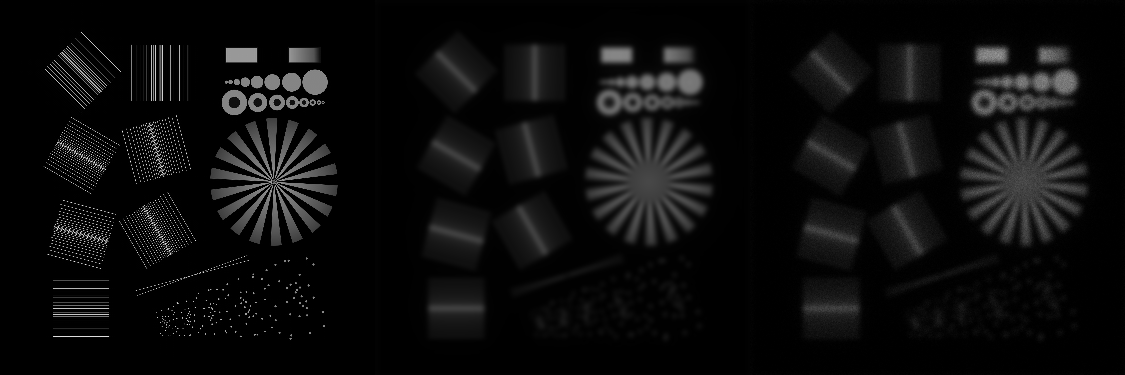

In [31]:
# load test images
img = Float32.(testimage("resolution_test_1920"))
img = resample(img, (3000, 3000))
psf = Float32.(generate_psf(size(img), 30))
psf = resample(psf, (3000, 3000))

psf_c = CuArray(psf)
# create a blurred, noisy version of that image
img_b = DeconvOptim.conv(img, psf)
img_n = poisson(img_b, 300);

img_n_c = CuArray(img_n)
h_view(img, img_b, img_n)

In [32]:
reg = TV(mode="forward")

#155 (generic function with 1 method)

In [43]:
@time resG, optim_res = deconvolution(img_n, psf, loss=Poisson(), regularizer=reg, λ=0.005, iterations=20)

 13.529876 seconds (41.42 k allocations: 9.391 GiB, 21.79% gc time)


(Float32[0.03838902 0.038122173 … 0.037886865 0.03794025; 0.038208596 0.03767466 … 0.037944626 0.037749168; … ; 0.037615906 0.03767209 … 0.036915254 0.037315194; 0.037897345 0.037821032 … 0.037320476 0.041068327],  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.794354e+06

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.94e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.75e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.00e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.46e-06 ≰ 0.0e+00
    |g(x)|                 = 4.32e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    20
    f(x) calls:    23
    ∇f(x) calls:   21
)

In [34]:
reg_gpu = TV_cuda(num_dims=2)

#16 (generic function with 1 method)

In [47]:
CUDA.@time resG_c, optim_res_c = deconvolution(img_n_c, psf_c, 
    loss=Poisson(), regularizer=reg_gpu, λ=0.005, iterations=20)

  0.942697 seconds (3.32 M CPU allocations: 56.288 MiB, 8.44% gc time) (1.55 k GPU allocations: 28.625 GiB, 18.40% gc time of which 52.19% spent allocating)


(Float32[0.03799148 0.03815172 … 0.037531845 0.037613805; 0.03806126 0.038159043 … 0.037557486 0.037504602; … ; 0.037482657 0.037421934 … 0.037348736 0.037264206; 0.03753636 0.037551247 … 0.03725968 0.041167222],  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.794356e+06

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.88e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.70e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.25e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.60e-06 ≰ 0.0e+00
    |g(x)|                 = 4.30e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    20
    f(x) calls:    23
    ∇f(x) calls:   21
)

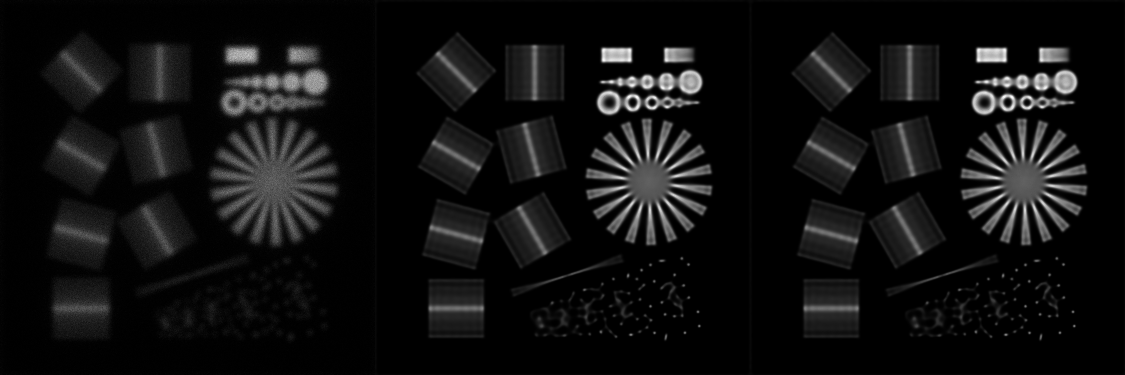

In [48]:
h_view(Array(img_n_c), Array(resG_c), Array(resG))

In [49]:
≈(Array(resG_c) .+ 1, Array(resG) .+ 1, rtol=1f-3)

true